In [ ]:
# Clone repo and go to repo's directory
!git clone https://github.com/kk-digital/kcg-ml-image-pipeline
!cd ./kcg-ml-image-pipeline

Cloning into 'kcg-ml-image-pipeline'...
remote: Enumerating objects: 11233, done.
remote: Counting objects: 100% (1429/1429), done.
remote: Compressing objects: 100% (491/491), done.
remote: Total 11233 (delta 1007), reused 1227 (delta 916), pack-reused 9804
Receiving objects: 100% (11233/11233), 68.10 MiB | 19.64 MiB/s, done.
Resolving deltas: 100% (7067/7067), done.
Updating files: 100% (299/299), done.


In [ ]:
# Install requirements
!pip install minio torch==2.0.1 torchinfo==1.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 259.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
# Get minio client
MINIO_ADDRESS = "123.176.98.90:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"

import sys
import os
import io
sys.path.append(os.path.abspath('./kcg-ml-image-pipeline/'))
from training_worker.ab_ranking.model.ab_ranking_linear import ABRankingModel as ABRankingLinearModel
from utility.minio.cmd import is_minio_server_accessible, connect_to_minio_client, download_from_minio, get_file_from_minio

minio_client = connect_to_minio_client(MINIO_ADDRESS, access_key, secret_key)


Connecting to minio client...
Successfully connected to minio client...


In [ ]:
import torch
# get linear positive embedding model
linear_model_path = "environmental/models/ranking/2023-12-08-00-score-linear-embedding-positive.pth"


model_file_data = get_file_from_minio(minio_client, 'datasets', linear_model_path)
if not model_file_data:
    raise Exception("No model file found at path: ", linear_model_path)

byte_buffer = io.BytesIO()
for data in model_file_data.stream(amt=8192):
    byte_buffer.write(data)
byte_buffer.seek(0)

linear_model = ABRankingLinearModel(inputs_shape=768)
model = torch.load(byte_buffer, map_location=torch.device('cpu'))
linear_model.model.load_state_dict(model['model_dict'])


<All keys matched successfully>

In [ ]:
# Get CLIP model
import math
import os
import time

import requests
from tqdm import tqdm

from configs import model_config
from utility.utils_logger import logger
from utility.labml.monit import section
from utility.minio.cmd import is_minio_server_accessible, connect_to_minio_client, download_from_minio

# create dirs
if not os.path.exists("input/model"):
  os.makedirs("input/model")
if not os.path.exists("./output"):
  os.makedirs("output")

config = model_config.ModelPathConfig()

def create_directory_tree_folders(config):
    config.create_paths()

with section("Creating directory tree folders."):
    create_directory_tree_folders(config)

logger.info("Downloading models. This may take a while.")

with section("Downloading CLIP model from minio"):
    # DOWNLOAD_BASE_CLIP_MODEL
    clip_path = "./kcg-ml-image-pipeline/input/model/clip/vit-large-patch14/model.safetensors"

    bucket_name = "models"
    object_name = "clip-vit-large-patch14/model.safetensors"
    download_from_minio(minio_client, bucket_name, object_name, clip_path)

!cp ./kcg-ml-image-pipeline/input/model/clip/vit-large-patch14/model.safetensors ./kcg-ml-image-pipeline/input/model/clip/txt_emb_model
!cp -r ./kcg-ml-image-pipeline/input ./

INFO:root:All model paths have been created.


Creating directory tree folders....[DONE]	5.47ms


INFO:root:Downloading models. This may take a while.


INFO: Downloading models. This may take a while.


In [ ]:
# Process CLIP model
from stable_diffusion.model.clip_text_embedder import CLIPTextEmbedder

# CLIP
text_embedder = CLIPTextEmbedder()
text_embedder.load_submodels()

Some weights of the model checkpoint at ./input/model/clip/txt_emb_model were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.9.layer_norm2.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.bias', 'vision_model.encoder.layers.12.self_attn.q_proj.weight', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.bias', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.13.layer_norm1.weight', 'vision_model.encoder.layers.21.self_attn.k_proj.bias', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.3.layer_norm2.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.22.self_attn.k_proj.bias', 'vision_model.encoder.layers.8.layer_norm2.weight', 'vision_model.embeddings.patch_embedding.weight', 'vision_model.encoder.layers.1.l

Loading tokenizer and transformer...[DONE]	5,558.92ms


CLIPTextEmbedder(
  (transformer): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768,

In [ ]:
from utility.clip.clip_text_embedder import tensor_attention_pooling, tensor_max_pooling, tensor_max_abs_pooling

# For getting prompt score using linear embedding model
def get_prompt_linear_embedding_score(text_embedder, linear_model, prompt):
  # get embedding of prompt first
  embedding, _, attention_mask = text_embedder.forward_return_all(prompt)
  # average using attention mask
  average_pooled = tensor_attention_pooling(embedding, attention_mask)

  # use linear model
  score = linear_model.predict_positive_or_negative_only_pooled(average_pooled)

  return score.item()

In [ ]:
# Get phrase scores probability
filename = "2023_11_29_phrase_scores_probability_09_environmental_positive.csv"

download_urls = ['https://mega.nz/file/4I42VbTY#iZvzE8gc_vPbhvA8YEFqyIYToUoZqSJfvrRLksL4qq8']

# Destination paths for data transfer (can be in Google Drive or session storage)
destination_paths = ['./']

# Mega user name and password. Leave as empty string for anonymous login
# note: not used
mega_user_email = ''
mega_user_password = ''

In [ ]:
!pip install mega.py

  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.2.3
    Uninstalling tenacity-8.2.3:
      Successfully uninstalled tenacity-8.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotly 5.15.0 requires tenacity>=6.2.0, but you have tenacity 5.1.5 which is incompatible.


In [ ]:
import os
from mega import Mega

# Create Mega User Object and Login
mega = Mega()
# mega_user = mega.login(mega_user_email, mega_user_password)


# Download files specified in download_urls to locations specified in destination_paths
for url, path in zip(download_urls, destination_paths):
    # Construct the full path to the file
    full_file_path = os.path.join(path, filename)

    # Check if file already exists
    if os.path.exists(full_file_path):
        print(f"File already exists: {full_file_path}")
    else:
        # Create directory if it does not exist
        os.makedirs(os.path.dirname(path), exist_ok=True)

        # Download file
        print(f"Downloading to {path}")
        mega.download_url(url, path)
        print(f"Download complete: {path}")


INFO:mega.mega:131072 of 62266258 downloaded


INFO: 131072 of 62266258 downloaded


INFO:mega.mega:393216 of 62266258 downloaded


INFO: 393216 of 62266258 downloaded


INFO:mega.mega:786432 of 62266258 downloaded


INFO: 786432 of 62266258 downloaded


INFO:mega.mega:1310720 of 62266258 downloaded


INFO: 1310720 of 62266258 downloaded


INFO:mega.mega:1966080 of 62266258 downloaded


INFO: 1966080 of 62266258 downloaded


INFO:mega.mega:2752512 of 62266258 downloaded


INFO: 2752512 of 62266258 downloaded


INFO:mega.mega:3670016 of 62266258 downloaded


INFO: 3670016 of 62266258 downloaded


INFO:mega.mega:4718592 of 62266258 downloaded


INFO: 4718592 of 62266258 downloaded


INFO:mega.mega:5767168 of 62266258 downloaded


INFO: 5767168 of 62266258 downloaded


INFO:mega.mega:6815744 of 62266258 downloaded


INFO: 6815744 of 62266258 downloaded


INFO:mega.mega:7864320 of 62266258 downloaded


INFO: 7864320 of 62266258 downloaded


INFO:mega.mega:8912896 of 62266258 downloaded


INFO: 8912896 of 62266258 downloaded


INFO:mega.mega:9961472 of 62266258 downloaded


INFO: 9961472 of 62266258 downloaded


INFO:mega.mega:11010048 of 62266258 downloaded


INFO: 11010048 of 62266258 downloaded


INFO:mega.mega:12058624 of 62266258 downloaded


INFO: 12058624 of 62266258 downloaded


INFO:mega.mega:13107200 of 62266258 downloaded


INFO: 13107200 of 62266258 downloaded


INFO:mega.mega:14155776 of 62266258 downloaded


INFO: 14155776 of 62266258 downloaded


INFO:mega.mega:15204352 of 62266258 downloaded


INFO: 15204352 of 62266258 downloaded


INFO:mega.mega:16252928 of 62266258 downloaded


INFO: 16252928 of 62266258 downloaded


INFO:mega.mega:17301504 of 62266258 downloaded


INFO: 17301504 of 62266258 downloaded


INFO:mega.mega:18350080 of 62266258 downloaded


INFO: 18350080 of 62266258 downloaded


INFO:mega.mega:19398656 of 62266258 downloaded


INFO: 19398656 of 62266258 downloaded


INFO:mega.mega:20447232 of 62266258 downloaded


INFO: 20447232 of 62266258 downloaded


INFO:mega.mega:21495808 of 62266258 downloaded


INFO: 21495808 of 62266258 downloaded


INFO:mega.mega:22544384 of 62266258 downloaded


INFO: 22544384 of 62266258 downloaded


INFO:mega.mega:23592960 of 62266258 downloaded


INFO: 23592960 of 62266258 downloaded


INFO:mega.mega:24641536 of 62266258 downloaded


INFO: 24641536 of 62266258 downloaded


INFO:mega.mega:25690112 of 62266258 downloaded


INFO: 25690112 of 62266258 downloaded


INFO:mega.mega:26738688 of 62266258 downloaded


INFO: 26738688 of 62266258 downloaded


INFO:mega.mega:27787264 of 62266258 downloaded


INFO: 27787264 of 62266258 downloaded


INFO:mega.mega:28835840 of 62266258 downloaded


INFO: 28835840 of 62266258 downloaded


INFO:mega.mega:29884416 of 62266258 downloaded


INFO: 29884416 of 62266258 downloaded


INFO:mega.mega:30932992 of 62266258 downloaded


INFO: 30932992 of 62266258 downloaded


INFO:mega.mega:31981568 of 62266258 downloaded


INFO: 31981568 of 62266258 downloaded


INFO:mega.mega:33030144 of 62266258 downloaded


INFO: 33030144 of 62266258 downloaded


INFO:mega.mega:34078720 of 62266258 downloaded


INFO: 34078720 of 62266258 downloaded


INFO:mega.mega:35127296 of 62266258 downloaded


INFO: 35127296 of 62266258 downloaded


INFO:mega.mega:36175872 of 62266258 downloaded


INFO: 36175872 of 62266258 downloaded


INFO:mega.mega:37224448 of 62266258 downloaded


INFO: 37224448 of 62266258 downloaded


INFO:mega.mega:38273024 of 62266258 downloaded


INFO: 38273024 of 62266258 downloaded


INFO:mega.mega:39321600 of 62266258 downloaded


INFO: 39321600 of 62266258 downloaded


INFO:mega.mega:40370176 of 62266258 downloaded


INFO: 40370176 of 62266258 downloaded


INFO:mega.mega:41418752 of 62266258 downloaded


INFO: 41418752 of 62266258 downloaded


INFO:mega.mega:42467328 of 62266258 downloaded


INFO: 42467328 of 62266258 downloaded


INFO:mega.mega:43515904 of 62266258 downloaded


INFO: 43515904 of 62266258 downloaded


INFO:mega.mega:44564480 of 62266258 downloaded


INFO: 44564480 of 62266258 downloaded


INFO:mega.mega:45613056 of 62266258 downloaded


INFO: 45613056 of 62266258 downloaded


INFO:mega.mega:46661632 of 62266258 downloaded


INFO: 46661632 of 62266258 downloaded


INFO:mega.mega:47710208 of 62266258 downloaded


INFO: 47710208 of 62266258 downloaded


INFO:mega.mega:48758784 of 62266258 downloaded


INFO: 48758784 of 62266258 downloaded


INFO:mega.mega:49807360 of 62266258 downloaded


INFO: 49807360 of 62266258 downloaded


INFO:mega.mega:50855936 of 62266258 downloaded


INFO: 50855936 of 62266258 downloaded


INFO:mega.mega:51904512 of 62266258 downloaded


INFO: 51904512 of 62266258 downloaded


INFO:mega.mega:52953088 of 62266258 downloaded


INFO: 52953088 of 62266258 downloaded


INFO:mega.mega:54001664 of 62266258 downloaded


INFO: 54001664 of 62266258 downloaded


INFO:mega.mega:55050240 of 62266258 downloaded


INFO: 55050240 of 62266258 downloaded


INFO:mega.mega:56098816 of 62266258 downloaded


INFO: 56098816 of 62266258 downloaded


INFO:mega.mega:57147392 of 62266258 downloaded


INFO: 57147392 of 62266258 downloaded


INFO:mega.mega:58195968 of 62266258 downloaded


INFO: 58195968 of 62266258 downloaded


INFO:mega.mega:59244544 of 62266258 downloaded


INFO: 59244544 of 62266258 downloaded


INFO:mega.mega:60293120 of 62266258 downloaded


INFO: 60293120 of 62266258 downloaded


INFO:mega.mega:61341696 of 62266258 downloaded


INFO: 61341696 of 62266258 downloaded


INFO:mega.mega:62266258 of 62266258 downloaded


INFO: 62266258 of 62266258 downloaded
Download complete: ./


In [ ]:
import os

import numpy as np
import pandas as pd

import zipfile

from scipy import stats
from matplotlib import pyplot

In [ ]:
!stat 2023_11_29_phrase_scores_probability_09_environmental_positive.csv

  File: 2023_11_29_phrase_scores_probability_09_environmental_positive.csv
  Size: 62266258  	Blocks: 121616     IO Block: 4096   regular file
Device: 34h/52d	Inode: 1573353     Links: 1
Access: (0600/-rw-------)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2023-12-08 06:59:39.035994108 +0000
Modify: 2023-12-08 07:00:08.729363567 +0000
Change: 2023-12-08 07:00:08.949381123 +0000
 Birth: 2023-12-08 06:59:39.035994108 +0000


# load prompt phrase scores

In [ ]:
#f = zipfile.ZipFile('./tmp/2023-12-04-phrase-scores-probability-environmental.zip')

#positive_phrase_df = pd.read_csv(f.open('2023_11_29_phrase_scores_probability_09_environmental_positive.csv'))
positive_phrase_df = pd.read_csv('2023_11_29_phrase_scores_probability_09_environmental_positive.csv')
positive_phrase_df

,index,phrase,occurrences,token length,boltzman_temperature,boltzman k,score,boltzman probability,normalized probability,unsmooth cumulative probability,normalized with epsilon,smooth cumulative probability
0,0,snes,19804,2,0.8,1.0,-12.678100,7.630203e+06,2.393384e-21,1.0,2.510299e-09,0.999004
1,1,pixel art,21903,2,0.8,1.0,0.730409,4.013139e-01,1.258811e-28,1.0,2.510299e-09,0.999023
2,2,tile based environment,27557,3,0.8,1.0,13.857334,3.001203e-08,9.413946e-36,1.0,2.510299e-09,0.999023
3,3,D environmental art side scrolling,43548,5,0.8,1.0,38.863129,7.988163e-22,2.505666e-49,1.0,2.510299e-09,0.999023
4,4,level design,31583,2,0.8,1.0,23.191227,2.571714e-13,8.066756e-41,1.0,2.510299e-09,0.999023
...,...,...,...,...,...,...,...,...,...,...,...,...
397956,397956,sanmian chidarakeno,1,7,0.8,1.0,0.203044,7.758431e-01,2.433606e-28,1.0,2.510299e-09,1.000000
397957,397957,intense glow,1,3,0.8,1.0,0.774378,3.798524e-01,1.191492e-28,1.0,2.510299e-09,1.000000
397958,397958,smoking with cigar,1,4,0.8,1.0,0.069281,9.170427e-01,2.876510e-28,1.0,2.510299e-09,1.000000
397959,397959,blank slates,1,3,0.8,1.0,0.925085,3.146305e-01,9.869091e-29,1.0,2.510299e-09,1.000000


# histogram of score

In [ ]:
score = positive_phrase_df["score"].values

# negate the score
score = score * -1

Text(0.5, 1.0, 'histogram of score (log scale)')

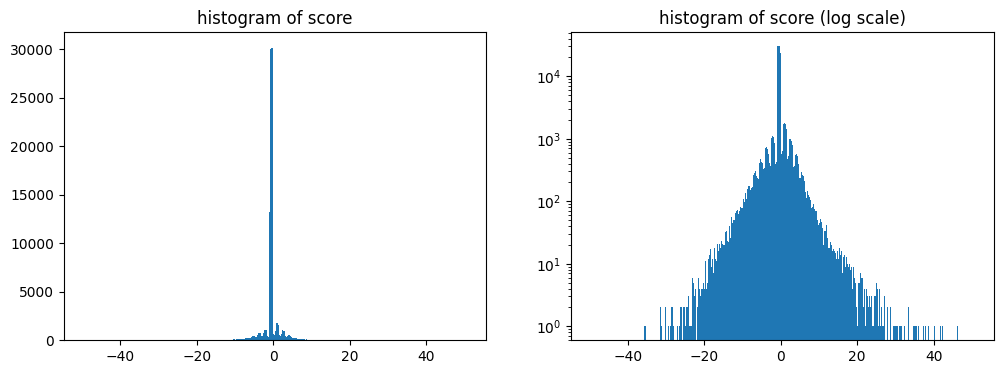

In [ ]:
pyplot.figure(figsize=(12, 4))

pyplot.subplot(1, 2, 1)

_ = pyplot.hist(score, bins=1024, log=False)
pyplot.title('histogram of score')

pyplot.subplot(1, 2, 2)

_ = pyplot.hist(score, bins=1024, log=True)
pyplot.title('histogram of score (log scale)')

# normal test

In [ ]:
score_mean = np.mean(score)
score_std = np.std(score)

print("score_mean= ", score_mean)
print("score_std= ", score_std)

score_mean=  -0.4641266598234501
score_std=  2.5635318510653944


In [ ]:
stats.kstest(score, 'norm', args=(np.mean(score), np.std(score)))

KstestResult(statistic=0.3156398291494339, pvalue=0.0, statistic_location=-0.999997, statistic_sign=-1)

# set probability formula

In [ ]:
boltzman_k = 1.0

def probablity_formula(score: np.ndarray, boltzman_temperature: float):

  p_array = np.exp(-(score / (boltzman_k * boltzman_temperature)))
  p_array_nomralized = p_array  / p_array.sum()  #np.linalg.norm(p_array )

  return p_array, p_array_nomralized

# trend of probability with temperature

Text(0.5, 1.0, 'trend of normalized probability (log scale)')

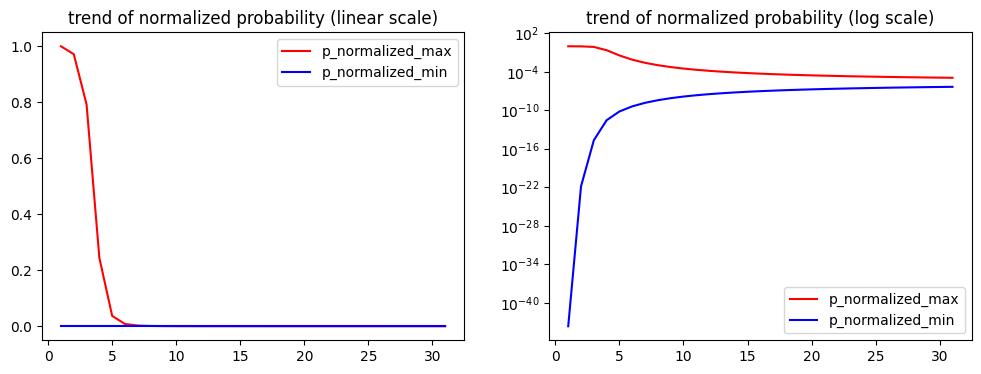

In [ ]:
#raw outputs

boltzman_temperatures = list()
p_normalized_maxs = list()
p_normalized_mins = list()

for n in range(1,32):
  boltzman_temperature = float(n)

  p_array, p_array_nomralized = probablity_formula(score, boltzman_temperature)

  p_max = np.max(p_array)
  p_min = np.min(p_array)

  # print("n=%i, min_max_ratio= %.2f, probability_min= %.6f, probability_max= %.6f" % (n, p_max/p_min, p_min, p_max))

  p_normalized_max = np.max(p_array_nomralized)
  p_normalized_min = np.min(p_array_nomralized)

  # print("n=%i, normalized_min_max_ratio= %.2f, normalized_probability_min= %.6f, normalized_probability_max= %.6f" % (n, p_normalized_max/p_normalized_min, p_normalized_min, p_normalized_max))

  boltzman_temperatures.append(boltzman_temperature)
  p_normalized_maxs.append(p_normalized_max)
  p_normalized_mins.append(p_normalized_min)


pyplot.figure(figsize=(12, 4))

pyplot.subplot(1, 2, 1)

pyplot.plot(boltzman_temperatures, p_normalized_maxs, color='red', label='p_normalized_max')
pyplot.plot(boltzman_temperatures, p_normalized_mins, color='blue', label='p_normalized_min')
pyplot.legend()
pyplot.title(f'trend of normalized probability (linear scale)')

pyplot.subplot(1, 2, 2)

pyplot.semilogy(boltzman_temperatures, p_normalized_maxs, color='red', label='p_normalized_max')
pyplot.semilogy(boltzman_temperatures, p_normalized_mins, color='blue', label='p_normalized_min')
pyplot.legend()
pyplot.title(f'trend of normalized probability (log scale)')


Note:
- As temperature increases, selection probability goes to uniform
-

# specific temperature and analysis

In [ ]:
boltzman_temperature = 8

p_array, p_array_nomralized = probablity_formula(score, boltzman_temperature)

## histogram of normalized probability

Text(0.5, 1.0, 'hist: normalized probability, temperature 8 (log scale)')

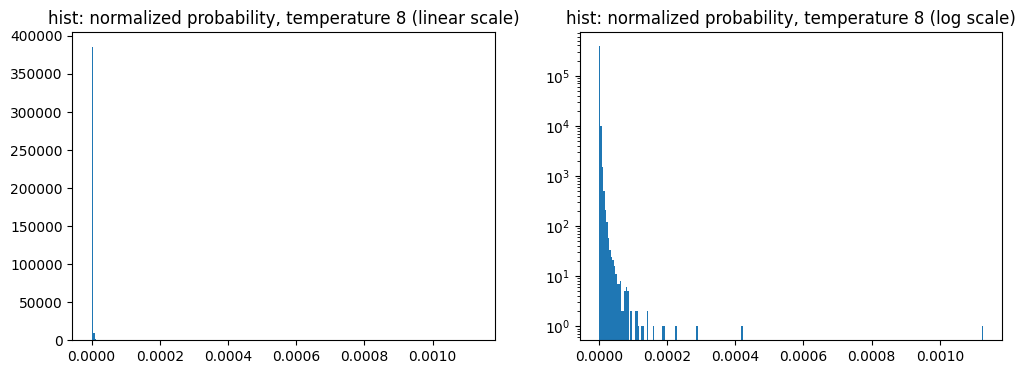

In [ ]:
pyplot.figure(figsize=(12, 4))

pyplot.subplot(1, 2, 1)

_ = pyplot.hist(p_array_nomralized, bins=256, log=False)
pyplot.title(f'hist: normalized probability, temperature {boltzman_temperature} (linear scale)')

pyplot.subplot(1, 2, 2)

_ = pyplot.hist(p_array_nomralized, bins=256, log=True)
pyplot.title(f'hist: normalized probability, temperature {boltzman_temperature} (log scale)')

## histogram of cumulative probability

In [ ]:
def get_normalized_probability(scores,
                              boltzman_k,
                              boltzman_temperature):
  probability = np.exp(-(score / (boltzman_k * boltzman_temperature)))
  #normalized_probability = probability / np.linalg.norm(probability) #probability.sum()
  normalized_probability = probability / probability.sum()

  p_max = np.max(probability)
  p_min = np.min(probability)

  print("-----------------------------------------------")
  print("boltzman_k = ", boltzman_k)
  print("boltzman_temperature = ", boltzman_temperature)
  print("probability_max= ", p_max)
  print("probability_min= ", p_min)
  # _ = pyplot.hist(normalized_probability, bins=256, log=True)
  # pyplot.title(f'histogram of normalized probability, temperature {boltzman_temperature} (log scale)')

  return normalized_probability

In [ ]:
def get_cumulative_probability(normalized_probability):
  # we need the sorted indexes to get correct index of chosen phrase
  sorted_normalized_probability = []
  sorted_indexes = sorted(range(len(normalized_probability)), key=lambda x: normalized_probability[x],
                                  reverse=True)
  for i in sorted_indexes:
      sorted_normalized_probability.append(normalized_probability[i])
  sorted_normalized_probability = np.array(sorted_normalized_probability)

  # sorted_normalized_probability = np.array(sorted(normalized_probability, reverse=True))
  cumulative_probability = sorted_normalized_probability.cumsum()

  # assert cumulative_probability.sum() == 1.0, "Error: culmulative probability does not add to 1.0"

  return sorted_indexes, cumulative_probability

In [ ]:
boltzman_temperature = 2.0
normalized_probability = get_normalized_probability(score,
                                                    boltzman_k,
                                                    boltzman_temperature)
sorted_indexes, cumulative_probability = get_cumulative_probability(normalized_probability)


-----------------------------------------------
boltzman_k =  1.0
boltzman_temperature =  2.0
probability_max=  65614890731.78187
probability_min=  1.0054468031210674e-11


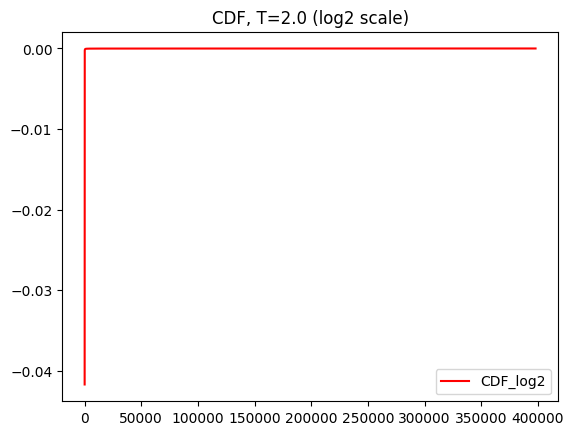

In [ ]:
### TODO:
### Assert than cumulative probability range is 0.00 to 1.00
#_ = pyplot.hist(cumulative_probability, bins=256, log=True)
#pyplot.title(f'histogram of cumulative probability, temperature {boltzman_temperature} (log scale)')

cumulative_probability_log2 = np.log2(cumulative_probability)

pyplot.title(f'CDF, T={boltzman_temperature} (log2 scale)')
pyplot.plot(cumulative_probability_log2, color='red', label='CDF_log2')
#pyplot.plot(boltzman_temperatures, p_normalized_mins, color='blue', label='p_normalized_min')
pyplot.legend()


Sampling

In [ ]:
#Add function
#uses cumulative probability distribution
#choose random number between 0.00 and 1.00
#use to choose next prompt from list
#keep adding phrases/prompts until token length would go over 75 (using token length parameter in csv)

#NOTE: make sure we dont use same prompt phrase twice in same generation

import math

# find the first element, whose cumulative prob is more than the random float
def find_first_element_binary_search(cumulative_prob_arr, random_float):
    low = 0
    high = len(cumulative_prob_arr) - 1
    mid = 0

    loop_count = 0
    while low < high:
        loop_count += 1
        assert loop_count < 32, "Error: binary search loop count is more than 32"

        mid = (high + low) / 2
        mid = math.floor(mid)

        # If random_float is greater, ignore left half
        if cumulative_prob_arr[mid] < random_float:
            low = mid + 1
        # If random_float is smaller, ignore right half
        elif cumulative_prob_arr[mid] >= random_float:
            high = mid - 1

        # use this index since sometimes the exact
        # random num is not in the list
        if low == high:
            # assert cumulative_prob_arr[low-1] < random_float
            # assert cumulative_prob_arr[low] >= random_float, "{} >= {}, next index val={}".format(cumulative_prob_arr[low], random_float, cumulative_prob_arr[low+1])
            # assert round(cumulative_prob_arr[low], 4) >= 0.0, "val={}".format(cumulative_prob_arr[low])
            # assert round(cumulative_prob_arr[low], 4) <= 1.0, "val={}".format(cumulative_prob_arr[low])

            return low


    # If we reach here, then the element was not present
    return -1

In [ ]:
import random

def generate_prompt(positive_phrase_df,
                    positive_phrase_origin_indexes,
                    positive_cumulative_probability_arr,
                    ):
    max_token_size = 75
    comma_token_size = 1

    positive_prompt_total_token_size = 0
    positive_prompt = []
    positive_prompt_indexes = []
    positive_used_phrase_dict = {}

    positive_cumulative_probability_arr_min = positive_cumulative_probability_arr.min()
    positive_cumulative_probability_arr_max = positive_cumulative_probability_arr.max()
    # positive prompt
    while positive_prompt_total_token_size < max_token_size:
        random_float = random.uniform(positive_cumulative_probability_arr_min,
                                      positive_cumulative_probability_arr_max)
        random_index = find_first_element_binary_search(positive_cumulative_probability_arr, random_float)
        if random_index in positive_used_phrase_dict:
            continue

        prompt_index = positive_phrase_origin_indexes[random_index]
        random_phrase = positive_phrase_df["phrase"][prompt_index]

        chosen_phrase_size = positive_phrase_df["token length"][prompt_index]
        sum_token_size = positive_prompt_total_token_size + chosen_phrase_size + comma_token_size
        if sum_token_size < max_token_size:
            # update used array
            positive_used_phrase_dict[random_index] = 1
            positive_prompt.append(str(random_phrase))
            positive_prompt_indexes.append(prompt_index)
            positive_prompt_total_token_size = sum_token_size
        else:
            break

    positive_prompt_str = ', '.join([prompt for prompt in positive_prompt])

    return positive_prompt_str, positive_prompt_indexes

In [ ]:
def get_variance(energies, mean):
  energies = np.array(energies)
  diff = energies - mean
  product = diff * diff
  sum = product.sum()
  variance = sum/len(energies)

  return variance

In [ ]:
def get_prompt_score(phrase_scores_arr, prompt_indexes):
  score = 0
  for index in prompt_indexes:
    score += phrase_scores_arr[index]

  return score

Test generate prompts

In [ ]:
# generate N prompts
prompts = []
prompt_indexes_arr = []
prompt_count = 5
for i in range(prompt_count):
  prompt, prompt_indexes = generate_prompt(positive_phrase_df,
                                           sorted_indexes,
                                           cumulative_probability)
  prompts.append(prompt)
  prompt_indexes_arr.append(prompt_indexes)

for i in range(len(prompts)):
  #Then add up "score" for each prompt phrase, to get the total score estimate for whole prompt
  prompt_score = get_prompt_score(score, prompt_indexes_arr[i])
  print("[{}]: Score = {}, Prompt = {}".format(i, prompt_score, prompts[i]))



[0]: Score = -393.70248699999996, Prompt = D side scrolling video game, D environmental side scrolling, hunter, extra legs, cum on stomach, ruins, squatting, river, buildings, fine, beautiful smile, gold lace trim, tattooed, shouhui, the most beautiful anime style art ever seen, thigh strap, cyberpunk city at background
[1]: Score = -441.51462999999995, Prompt = D environmental side scrolling, ruins, extra legs, D side scrolling video game, male only,  man, river, squatting, hunter, wizard, fine, low cut, a valley forgotten by time, delicate and beautiful, color professional photo of emmabinnya, tattooed, figurative, bob haircut
[2]: Score = -330.926641, Prompt = D environmental side scrolling, extra legs, D side scrolling video game, squatting, hunter, ruins, a man in a green and brown armor, a ghost bathing in the blood water, black bow, river, dusk, wizard, tattooed, walking in labyrinth of alleys, insanely detailed, yellow shorts
[3]: Score = -466.707969, Prompt = D side scrolling 

Graph average prompt energy per temperature

In [ ]:
from tqdm import tqdm
# generate N prompts
prompt_count = 1024

average_linear_embedding_scores_per_temp = []
average_energy_per_temp = []
variance_per_temp = []
temperature_range = [i for i in range(4,33)]
print("temperature_range=", temperature_range)
for temperature in tqdm(temperature_range):
  prompt_indexes_arr = []
  prompt_str_arr = []
  normalized_probability = get_normalized_probability(score,
                                                      boltzman_k,
                                                      temperature)
  sorted_indexes, cumulative_probability = get_cumulative_probability(normalized_probability)

  # generate prompt
  for i in range(prompt_count):
    prompt, prompt_indexes = generate_prompt(positive_phrase_df,
                                            sorted_indexes,
                                            cumulative_probability)
    prompt_indexes_arr.append(prompt_indexes)
    prompt_str_arr.append(prompt)

  prompt_energies = []
  prompt_linear_embedding_scores = []
  for i in range(len(prompt_indexes_arr)):
    #Then add up "score" for each prompt phrase, to get the total score estimate for whole prompt
    prompt_energy = get_prompt_score(score, prompt_indexes_arr[i])
    prompt_energies.append(prompt_energy)

    # get linear embedding score
    linear_embedding_score = get_prompt_linear_embedding_score(text_embedder,
                                                               linear_model,
                                                               prompt_str_arr[i])
    prompt_linear_embedding_scores.append(linear_embedding_score)

  average_energy = np.mean(prompt_energies)
  variance = get_variance(prompt_energies, average_energy)
  average_linear_embedding_score = np.mean(prompt_linear_embedding_scores)
  print("mean energy = ", average_energy)
  print("variance = ", variance)
  print("linear embedding mean score = ", average_linear_embedding_score)

  average_energy_per_temp.append(average_energy)
  variance_per_temp.append(variance)
  average_linear_embedding_scores_per_temp.append(average_linear_embedding_score)

pyplot.figure(figsize=(16, 4))
# mean energy
pyplot.subplot(1, 2, 1)
_ = pyplot.plot(average_energy_per_temp, color='red', label='Average Energy', zorder=0)
pyplot.title(f'Average Prompt Energy vs Temperature')
pyplot.xlabel("Temperature")
pyplot.ylabel("Average Prompt Energy")
pyplot.xticks([i for i in range(len(temperature_range))], labels=temperature_range)
pyplot.xticks(rotation=90)
pyplot.legend()

# variance
pyplot.subplot(1, 2, 2)
_ = pyplot.plot(variance_per_temp, color='red', label='Variance', zorder=0)
pyplot.title(f'Variance vs Temperature')
pyplot.xlabel("Temperature")
pyplot.ylabel("Variance")
pyplot.xticks([i for i in range(len(temperature_range))], labels=temperature_range)
pyplot.xticks(rotation=90)
pyplot.legend()

# linear embedding mean energy
pyplot.subplot(1, 2, 3)
_ = pyplot.plot(average_linear_embedding_scores_per_temp, color='red', label='Linear Embedding Average Energy', zorder=0)
pyplot.title(f'Linear Embedding Average Prompt Energy vs Temperature')
pyplot.xlabel("Temperature")
pyplot.ylabel("Linear Embedding Average Prompt Energy")
pyplot.xticks([i for i in range(len(temperature_range))], labels=temperature_range)
pyplot.xticks(rotation=90)
pyplot.legend()

temperature_range= [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


  0%|          | 0/29 [00:00<?, ?it/s]

-----------------------------------------------
boltzman_k =  1.0
boltzman_temperature =  4
probability_max=  256154.03711786756
probability_min=  3.1708781167384334e-06


  3%|▎         | 1/29 [06:32<3:03:03, 392.26s/it]

mean energy =  -75.74432066796875
variance =  1907.4335975753131
linear embedding mean score =  10889.852532863617
-----------------------------------------------
boltzman_k =  1.0
boltzman_temperature =  5
probability_max=  21222.7160756042
probability_min=  3.989731218986584e-05


  3%|▎         | 1/29 [07:22<3:26:18, 442.09s/it]


KeyboardInterrupt: ignored

TODO: Max Entropy Sampling
- problem: assign probabilites
- solution:
-- assign probabilites so that that
- sum(P(x)*score(x)) = EnergyTarget
- and subject to MAX sum(p(x)*ln(P(x)); maximum entropy
-- example: choose probabilities so that they average to EnergyTarget

Then sample from the probability distribution sequentially

